In [1]:
from extern_funcs_cython import interpolate, ln, lstm_state_calculator
from fusion import fusion_quantize_cython, prep_cython
from keyframe_buffer import KeyframeBuffer
from pynq import Overlay, allocate
import numpy as np
import math
import time
import nngen_ctrl as ng

In [2]:
params = np.load("../params_nngen/params.npz")['arr_0']
inputs_npz = np.load("../params_nngen/inputs.npz")
outputs_npz = np.load("../params_nngen/outputs.npz")
predictions_npz = np.load("../params_nngen/predictions.npz")
intrinsics_npz = np.load("../params_nngen/intrinsics.npz")

In [3]:
output_files = ['feature_half',
                'cell_state',
                'hidden_state',
                'depth_org']
cell_state_idx = output_files.index('cell_state')
input_files = ['reference_image',
               'hidden_state',
               'cell_state']
hidden_state_idx = len(output_files) + input_files.index('hidden_state')

In [4]:
chunk_size = 64
def get_end_addr(addr, memory_size):
    return int(math.ceil((addr + memory_size) / chunk_size)) * chunk_size

def shape2size(shape):
    size = 1
    for s in shape:
        size *= s
    return size

In [5]:
axi_datawidth = 128
act_bit = 16
num_align_words = axi_datawidth // act_bit

output_offset = 0
outputs = []
output_aligned_shapes = []
addrs = [output_offset]
for file in output_files:
    output = outputs_npz[file]
    output_aligned_shape = (*output.shape[:-1], int(math.ceil(output.shape[-1] / num_align_words)) * num_align_words)
    outputs.append(output)
    output_aligned_shapes.append(output_aligned_shape)
    addrs.append(get_end_addr(addrs[-1], shape2size(output_aligned_shape) * (act_bit // 8)))

input_offset = addrs[-1]
inputs = []
for file in input_files:
    input = inputs_npz[file]
    lack = (num_align_words - (input.shape[-1] % num_align_words)) % num_align_words
    if lack > 0:
        input = np.append(input, np.zeros(list(input.shape[:-1]) + [lack], dtype=input.dtype), axis=input.ndim-1)
    input = np.reshape(input, [-1]).astype(np.int16)
    inputs.append(input)
    addrs.append(get_end_addr(addrs[-1], input.size * (act_bit // 8)))
cell_state_offset = addrs[-2] # change output cell_state addr to input addr
addrs[cell_state_idx] = cell_state_offset
hidden_state_offset = 176869824
addrs[hidden_state_idx] = hidden_state_offset
param_offset = addrs[-1]
print(output_offset, input_offset, param_offset)
print(addrs)

0 208896 319488
[0, 313344, 104448, 110592, 208896, 176869824, 313344, 319488]


In [6]:
bitfile = 'design_1.bit'
ipname = 'dvmvs_0'

overlay = Overlay(bitfile)
# overlay.ip_dict
ip = ng.nngen_core(overlay, ipname)

In [7]:
memory_size = 1024 * 1024 * 192
buf = allocate(shape=(memory_size,), dtype=np.uint8)
buf[param_offset:param_offset + params.size] = params.view(np.int8)

In [8]:
ip.set_global_buffer(buf)
ip.write_buffer_address(cell_state_idx, cell_state_offset)
for i in range(7):
    print(ip.read_buffer_address(i))

0
313344
104448
110592
208896
307200
313344


In [9]:
def prepare_input_value(value, lshift):
    ret = value * (1 << lshift)
    ret = np.clip(ret, -1 * 2 ** (16 - 1) - 1, 2 ** (16 - 1))
    return np.round(ret.astype(np.float64)).astype(np.int16)

In [10]:
reference_image_preds = predictions_npz["reference_image"]
feature_halfs = predictions_npz["feature_half"]
measurement_features = predictions_npz["measurement_features"]
hidden_states = predictions_npz["hidden_state"]
cell_states = predictions_npz["cell_state"]

n_measurement_frames = intrinsics_npz["n_measurement_frames"]
reference_images = intrinsics_npz["reference_image"]
reference_poses = intrinsics_npz["reference_pose"]

max_n_measurement_frames = 2
min_depth = 0.25
max_depth = 20.0
inverse_depth_base = 1 / max_depth
inverse_depth_multiplier = 1 / min_depth - 1 / max_depth

test_keyframe_buffer_size = 30
test_keyframe_pose_distance = 0.1
test_optimal_t_measure = 0.15
test_optimal_R_measure = 0.0

calc = lstm_state_calculator(intrinsics_npz, prepare_input_value, 14-1)
# org_hidden_state = prepare_input_value(intrinsics_npz["hidden_state"][0].transpose(0, 2, 3, 1), 14-1).reshape(-1)
# org_cell_state = prepare_input_value(intrinsics_npz["cell_state"][0].transpose(0, 2, 3, 1), 12).reshape(-1)
org_hidden_state = np.zeros((3072), dtype=np.int16)
org_cell_state = np.zeros((3072), dtype=np.int16)

reference_pads = np.zeros([1, 64, 96, 5], dtype=np.int16)

In [11]:
half_K = intrinsics_npz["half_K"][0]
inv_half_K = np.linalg.inv(half_K)

def get_warp_grid_for_cost_volume_calculation(width, height):
    x = np.linspace(0, width - 1, num=int(width))
    y = np.linspace(0, height - 1, num=int(height))
    ones = np.ones(shape=(height, width))
    x_grid, y_grid = np.meshgrid(x, y)
    warp_grid = np.stack((x_grid, y_grid, ones), axis=-1)
    warp_grid = warp_grid.astype(np.float32).reshape(-1, 3).T
    return warp_grid
warp_grid = get_warp_grid_for_cost_volume_calculation(int(96 / 2), int(64 / 2))

def round_and_clip(input):
    info = np.iinfo(np.int16)
    return np.clip(np.round(input).astype(np.int64), info.min, info.max).astype(np.int16)

In [12]:
# opcode -> (func, input.addr, input.aligned_shape, output.addr, output.aligned_shape)
externs = {0x79: (None, 0, (1, 32, 48, 32), 175680960, (1, 32, 48, 64)),
           0x102: (None, 307200, (1, 32, 48, 512), hidden_state_offset, (1, 32, 48, 512)),
           0x104: (ln(12), 176912832, (1, 2, 3, 512), 176931264, (1, 2, 3, 512)),
           0x105: (ln(12), 176937408, (1, 2, 3, 512), cell_state_offset, (1, 2, 3, 512)),
           0x107: (interpolate(4, 6, 0, 'bilinear'), 104448, (1, 2, 3, 512), 176949696, (1, 4, 6, 512)),
           0x113: (interpolate(8, 12, 0, 'bilinear'), 177035712, (1, 4, 6, 256), 177048000, (1, 8, 12, 256)),
           0x115: (interpolate(8, 12, 0, 'bilinear'), 177097152, (1, 4, 6, 8), 177097536, (1, 8, 12, 8)),
           0x120: (interpolate(16, 24, 0, 'bilinear'), 177200448, (1, 8, 12, 128), 177225024, (1, 16, 24, 128)),
           0x122: (interpolate(16, 24, 0, 'bilinear'), 177323328, (1, 8, 12, 8), 177324864, (1, 16, 24, 8)),
           0x127: (interpolate(32, 48, 0, 'bilinear'), 177539904, (1, 16, 24, 64), 177589056, (1, 32, 48, 64)),
           0x129: (interpolate(32, 48, 0, 'bilinear'), 177785664, (1, 16, 24, 8), 177791808, (1, 32, 48, 8)),
           0x134: (interpolate(64, 96, 0, 'bilinear'), 178357056, (1, 32, 48, 8), 178774848, (1, 64, 96, 8)),
           0x135: (interpolate(64, 96, 0, 'bilinear'), 178258752, (1, 32, 48, 32), 178381632, (1, 64, 96, 32))}

In [39]:
sw = []
hw = []
c2s = {0x79: 801, 0x102:1070, 0x104: 1100, 0x105: 1142, 0x107: 1158, 0x113: 1214, 0x115: 1242, 0x120: 1288, 0x122: 1316, 0x127: 1362, 0x129: 1390, 0x134: 1461, 0x135: 1436}
for s in [0x102, 0x104, 0x105, 0x107, 0x113, 0x115, 0x120, 0x122, 0x127, 0x129, 0x134, 0x135]:
    print(s)
    ip.base_ip.write(52, c2s[s])

    def run_extern(code, warped_image2s=None):
        if code == 0x102:
            return None
            
        func, input_addr, input_aligned_shape, output_addr, output_aligned_shape = externs[code]
        input = buf[input_addr:input_addr + shape2size(input_aligned_shape) * (act_bit // 8)].view(np.int16)
        
        start_time = time.time()
        input = input.reshape(input_aligned_shape)
        if input.shape[-1] == 8:
            input = input[:,:,:,:1]
        if warped_image2s is None:
            output = func(input)
        else:
            output = np.array(fusion_quantize_cython(np.array(input), warped_image2s), dtype=np.int16)
            # output = round_and_clip(np.concatenate([np.sum(input * warped_image2.astype(np.int32), axis=3, keepdims=True) for warped_image2 in warped_image2s], axis=3) / (1 << 16))
            # output = round_and_clip(np.array([np.sum(np.array(input, dtype=np.int32) * warped_image2, axis=3) for warped_image2 in warped_image2s]).transpose(1, 2, 3, 0) / (1 << 16))
        if output.shape != output_aligned_shape:
            output = np.append(output, np.zeros((*output.shape[:-1], 7), dtype=output.dtype), axis=output.ndim-1)
        output = output.astype(np.int16).reshape(-1)
        if code == s:
            sw.append(time.time() - start_time) 
            
        buf[output_addr:output_addr + shape2size(output_aligned_shape) * (act_bit // 8)] = output.view(np.uint8)

        if code == 0x79: return input

    keyframe_buffer = KeyframeBuffer(buffer_size=test_keyframe_buffer_size,
                                    keyframe_pose_distance=test_keyframe_pose_distance,
                                    optimal_t_score=test_optimal_t_measure,
                                    optimal_R_score=test_optimal_R_measure,
                                    store_return_indices=False)
    hidden_state = None
    previous_depth = None
    previous_pose = None

    start_time_total = time.time()

    idx = 0
    depths = []
    for n in range(len(reference_images)):
        start_time = time.time()
        response = keyframe_buffer.try_new_keyframe(reference_poses[n][0])

        print("evaluating %05d.png (response: %d) ..." % (n + 3, response))
        if response == 2 or response == 4 or response == 5:
            continue
        elif response == 3:
            hidden_state = None
            previous_depth = None
            previous_pose = None
            continue

        reference_image_value = prepare_input_value(reference_images[n].transpose(0, 2, 3, 1), 12)
        reference_image_value = np.append(reference_image_value, reference_pads, axis=3).reshape(-1)
        addr = addrs[len(output_files)]
        buf[addr:addr + reference_image_value.size * (act_bit // 8)] = reference_image_value.view(np.uint8)
        # print("prep", time.time() - start_time)
        
        ip.run()

        if response == 0:
            for i in range(len(externs)):
                code = ip.wait_extern()
                ip.resume_extern()
                if i == 0:
                    _, input_addr, input_aligned_shape, _, _ = externs[code]
                    feature_half_value = buf[input_addr:input_addr + shape2size(input_aligned_shape) * (act_bit // 8)].view(np.int16).reshape(input_aligned_shape)
                    keyframe_buffer.add_new_keyframe(reference_poses[n][0], feature_half_value.copy())
            ip.wait()
            print(time.time() - start_time)
            continue
        
        # start_time_1 = time.time()
        ### prepare fusion ###
        measurement_poses_value = []
        measurement_features_value = []
        frame_number_value = idx
        measurement_frames = keyframe_buffer.get_best_measurement_frames(reference_poses[n][0], max_n_measurement_frames)
        for measurement_frame in measurement_frames:
            measurement_poses_value.append(measurement_frame[0])
            measurement_features_value.append(measurement_frame[1])
        # print("kfb_get", time.time() - start_time_1)

        # start_time_1 = time.time()
        inv_pose2s = np.linalg.inv(np.array(measurement_poses_value))
        warped_image2s = np.array(prep_cython(len(measurement_frames), np.array(measurement_features_value), half_K, inv_half_K, reference_poses[n][0], inv_pose2s, warp_grid), dtype=np.int16)
        # print("fusion.prep", time.time() - start_time_1)

        for i in range(len(externs)):
            code = ip.wait_extern()
            # print("e", time.time() - start_time)
            if i == 0:
                feature_half_value = run_extern(code, warped_image2s)
                ip.resume_extern()

                # start_time_1 = time.time()
                ### prepare hidden_state and cell_state ###
                if previous_depth is not None:
                    hidden_state_value = calc(hidden_state, previous_depth, previous_pose, reference_poses[n]).reshape(-1)
                    addr = addrs[hidden_state_idx]
                    buf[addr:addr + hidden_state_value.size * (act_bit // 8)] = hidden_state_value.view(np.uint8)
                else:
                    addr = addrs[hidden_state_idx+1]
                    buf[addr:addr + org_cell_state.size * (act_bit // 8)] = org_cell_state.view(np.uint8)
                    addr = addrs[hidden_state_idx]
                    buf[addr:addr + org_hidden_state.size * (act_bit // 8)] = org_hidden_state.view(np.uint8)
                # print("lstm", time.time() - start_time_1)
            elif i == 1:
                if code == s:
                    sw.append(0)
                ip.resume_extern()

                # start_time_1 = time.time()
                keyframe_buffer.add_new_keyframe(reference_poses[n][0], feature_half_value.copy())
                # print("kfb_add", time.time() - start_time_1)
            else:
                run_extern(code)
                ip.resume_extern()
            # print("s", time.time() - start_time)

        ### prepare hidden_state and cell_state ###
        addr = addrs[2]
        output_aligned_shape = output_aligned_shapes[2]
        hidden_state = buf[addr:addr + shape2size(output_aligned_shape) * (act_bit // 8)].view(np.int16).reshape(output_aligned_shape)

        previous_pose = reference_poses[n]

        ip.wait()

        # start_time_1 = time.time()
        ### prepare previous_depth and hidden_state ###
        addr = addrs[3]
        output_aligned_shape = output_aligned_shapes[3]
        depth_org = buf[addr:addr + shape2size(output_aligned_shape) * (act_bit // 8)].view(np.int16).reshape(output_aligned_shape)
        depth_org = depth_org[:,:,:,:1]
        depth_org = (depth_org.transpose(0, 3, 1, 2) / (1 << 14)).astype(np.float32)
        inverse_depth_full = inverse_depth_multiplier * depth_org + inverse_depth_base
        previous_depth = 1.0 / inverse_depth_full
        # print("post", time.time() - start_time_1)

        hw.append(ip.base_ip.read(48))
        print(time.time() - start_time)

        depths.append(previous_depth)
        idx += 1

    # print(time.time() - start_time_total)


258
evaluating 00003.png (response: 0) ...
0.22982192039489746
evaluating 00004.png (response: 2) ...
evaluating 00005.png (response: 2) ...
evaluating 00006.png (response: 2) ...
evaluating 00007.png (response: 2) ...
evaluating 00008.png (response: 2) ...
evaluating 00009.png (response: 1) ...
0.3022592067718506
evaluating 00010.png (response: 2) ...
evaluating 00011.png (response: 2) ...
evaluating 00012.png (response: 1) ...
0.282764196395874
evaluating 00013.png (response: 1) ...
0.7288126945495605
evaluating 00014.png (response: 1) ...
0.2747812271118164
evaluating 00015.png (response: 2) ...
evaluating 00016.png (response: 1) ...
0.27771830558776855
evaluating 00017.png (response: 1) ...
0.30029869079589844
evaluating 00018.png (response: 1) ...
0.2776775360107422
evaluating 00019.png (response: 1) ...
0.2978053092956543
evaluating 00020.png (response: 1) ...
0.2762289047241211
evaluating 00021.png (response: 1) ...
0.6986587047576904
evaluating 00022.png (response: 1) ...
0.273

In [40]:
sw = np.array(sw).reshape(-1, 11)
hw = np.array(hw).reshape(-1, 11) / (187.512 * 1000000)
assert sw.shape == hw.shape, (sw.shape, hw.shape)
print(sw.shape)

(12, 11)


In [41]:
print(np.sum((hw - sw), axis=0) * 1000, "ms")

[4.94089707 4.96580553 5.51197317 4.50507789 4.80186842 4.5639167
 4.85223226 4.72307276 4.7232206  4.65191353 4.59333925] ms


In [42]:
in_size = np.array([49152, 3072, 3072, 3072, 6144, 192, 12288, 768, 24576, 3072, 12288, 49152])
out_size = np.array([98304, 3072, 3072, 12288, 24576, 768, 49152, 3072, 98304, 12288, 49152, 196608])
io_size = in_size + out_size

In [48]:
# np.savez_compressed('overheads', hw=hw, sw=sw)

In [44]:
data = np.median(hw - sw, axis=1)
print(data)

[4.94901660e-05 3.73794761e-04 3.50511534e-04 3.02948197e-04
 3.32628142e-04 2.85575053e-04 4.06369639e-04 3.03171403e-04
 6.00895486e-04 3.75119674e-04 4.19518431e-04 8.32994686e-04]


In [47]:
np.corrcoef(data[1:], (in_size + out_size)[1:])[0,1]

0.9789855120393702

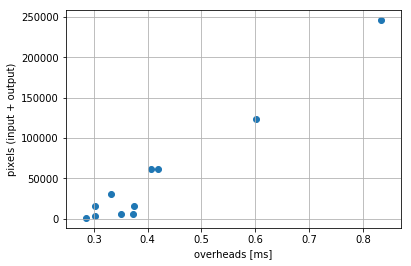

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.scatter(data[1:] * 1000, io_size[1:])
# plt.xlim(0, 0.007 * 1000)
plt.xlabel('overheads [ms]')
plt.ylabel('pixels (input + output)')
plt.grid()
plt.show()

In [21]:
predictions = predictions_npz["prediction"]
print(len(predictions), len(depths))
for prediction, depth in zip(predictions, depths):
    print(np.corrcoef(prediction.reshape(-1), depth.reshape(-1))[0, 1])

11 11
0.9981648390543427
0.9992443523984911
0.9974589782005606
0.9984591642086847
0.9992527954355334
0.9986021878380238
0.9969824587282724
0.9988970198837177
0.9997805005553531
0.9998966528702832
0.9991100371905802


In [22]:
start_time_total = time.time()
ip.run()
start_time = time.time()
for i in range(len(externs)):
    code = ip.wait_extern()
    print(time.time() - start_time)
    ip.resume_extern()
    start_time = time.time()
ip.wait()
print(time.time() - start_time)
print(time.time() - start_time_total)

0.12224817276000977
0.027622461318969727
0.011040449142456055
9.965896606445312e-05
2.5510787963867188e-05
0.00558924674987793
0.0021872520446777344
0.0035696029663085938
0.0022215843200683594
0.004235506057739258
0.0044095516204833984
0.009844064712524414
0.0022945404052734375
0.03197073936462402
0.23138737678527832
